## Project - Data Mining
## Compiled by - Ajay Kumar

#### Inporting the necessary library

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Problem 1: Clustering

#### A leading bank wants to develop a customer segmentation to give promotional offers to its customers. They collected a sample that summarizes the activities of users during the past few months. You are given the task to identify the segments based on credit card usage

#### Loading the Dataset

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Data Science/Project Data Mining/bank_marketing_part1_Data.csv')

In [ ]:
kmeans_df = df.copy(deep=True)

In [ ]:
df.head()

,spending,advance_payments,probability_of_full_payment,current_balance,credit_limit,min_payment_amt,max_spent_in_single_shopping
0,19.94,16.92,0.8752,6.675,3.763,3.252,6.550
1,15.99,14.89,0.9064,5.363,3.582,3.336,5.144
2,18.95,16.42,0.8829,6.248,3.755,3.368,6.148
3,10.83,12.96,0.8099,5.278,2.641,5.182,5.185
4,17.99,15.86,0.8992,5.890,3.694,2.068,5.837


In [ ]:
df.shape

(210, 7)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   spending                      210 non-null    float64
 1   advance_payments              210 non-null    float64
 2   probability_of_full_payment   210 non-null    float64
 3   current_balance               210 non-null    float64
 4   credit_limit                  210 non-null    float64
 5   min_payment_amt               210 non-null    float64
 6   max_spent_in_single_shopping  210 non-null    float64
dtypes: float64(7)
memory usage: 11.6 KB


In [ ]:
df.columns

Index(['spending', 'advance_payments', 'probability_of_full_payment',
       'current_balance', 'credit_limit', 'min_payment_amt',
       'max_spent_in_single_shopping'],
      dtype='object')

## Q1.1 Read the data and do exploratory data analysis. Describe the data briefly.

In [ ]:
df.describe()

,spending,advance_payments,probability_of_full_payment,current_balance,credit_limit,min_payment_amt,max_spent_in_single_shopping
count,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000
mean,14.847524,14.559286,0.870999,5.628533,3.258605,3.700201,5.408071
std,2.909699,1.305959,0.023629,0.443063,0.377714,1.503557,0.491480
min,10.590000,12.410000,0.808100,4.899000,2.630000,0.765100,4.519000
25%,12.270000,13.450000,0.856900,5.262250,2.944000,2.561500,5.045000
50%,14.355000,14.320000,0.873450,5.523500,3.237000,3.599000,5.223000
75%,17.305000,15.715000,0.887775,5.979750,3.561750,4.768750,5.877000
max,21.180000,17.250000,0.918300,6.675000,4.033000,8.456000,6.550000


In [ ]:
# Checking the Nan values in the Dataset
df.isnull().sum().any()

False

In [ ]:
# Checking the Duplicates values
df.duplicated().sum()

0

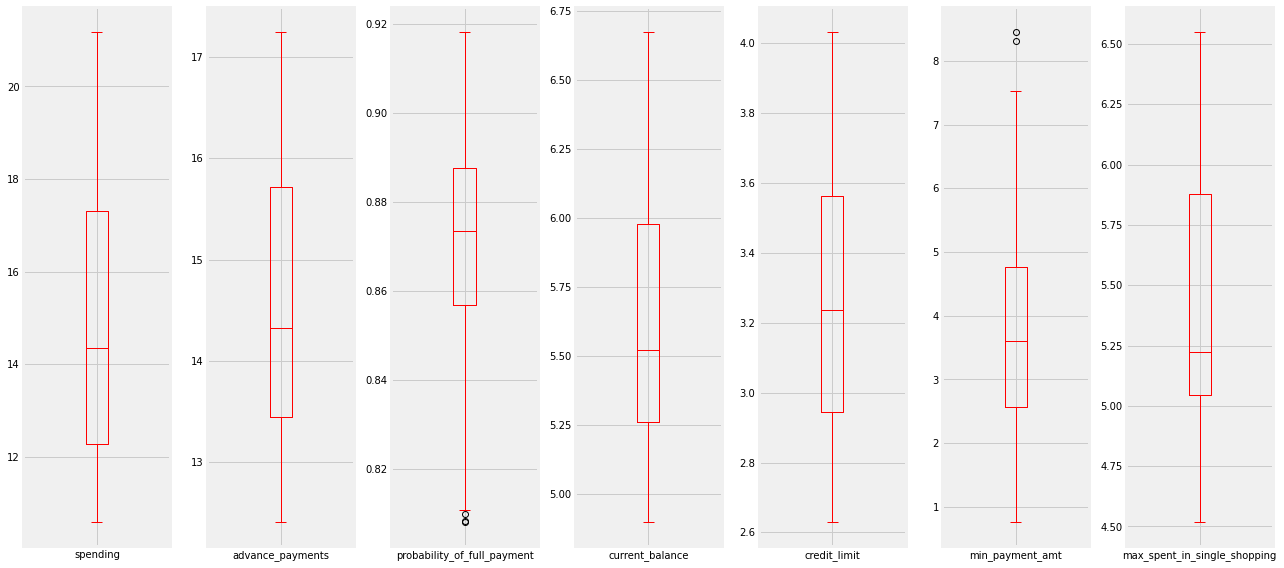

In [ ]:
# Checking for outliers
df.plot(kind= 'box', figsize=(18,8), color='red', subplots=True)
plt.tight_layout()
plt.show()

There are lower outliers in probability_of_full_payment and upper outliers in min_payment_amt columns

In [ ]:
# Treating the outliers
def out_limit(col):
  Q1, Q3 = col.quantile([0.25,0.75])
  IQR = Q3 -Q1
  lower_range  = Q1 - (1.5*IQR)
  upper_range = Q3 + (1.5*IQR)
  return lower_range, upper_range 

In [ ]:
ol_col = ['probability_of_full_payment', 'min_payment_amt']

for col in ol_col:
  lr, ur = out_limit(df[col])
  df[col] = np.where(df[col] < lr, lr, df[col])
  df[col] = np.where(df[col] > ur, ur, df[col])

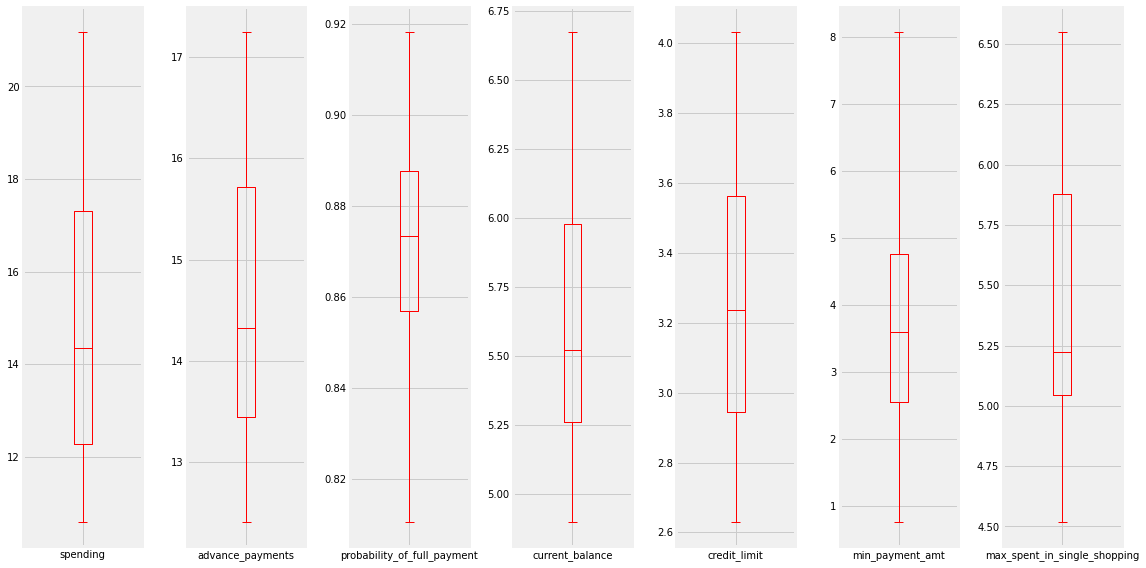

In [ ]:
df.plot(kind= 'box', figsize=(16,8), color='red', subplots=True)
plt.tight_layout()
plt.show()

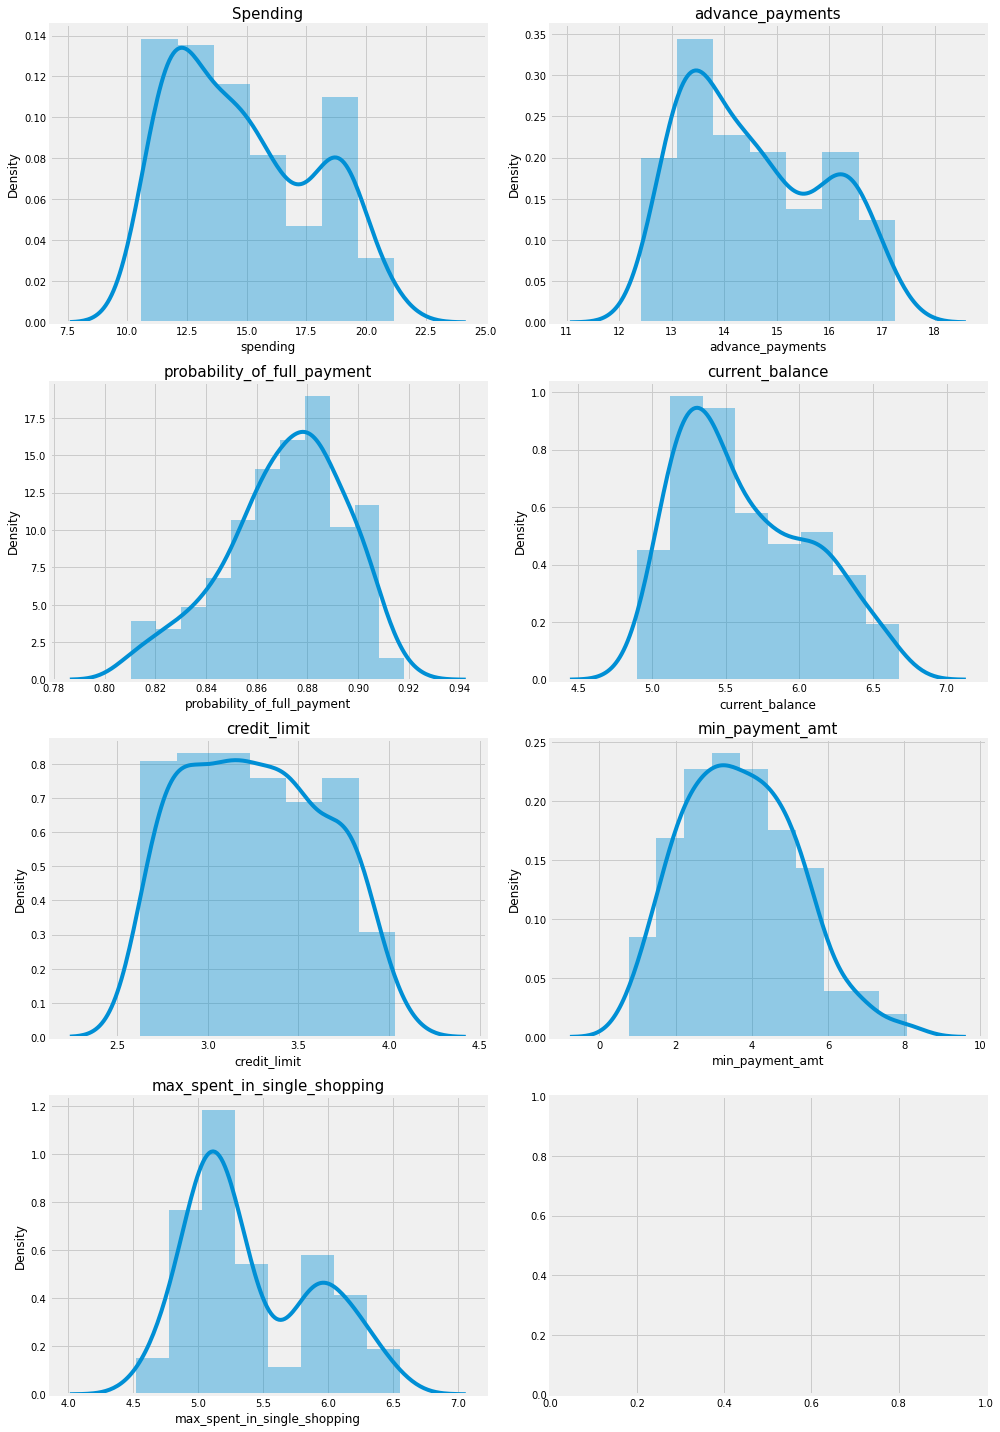

In [ ]:
# Univariate Analysis
fig, axes = plt.subplots(nrows=4, ncols=2)
fig.set_size_inches(14,20)
a = sns.distplot(df['spending'], ax = axes[0][0]);
a.set_title('Spending', fontsize = 15)

a = sns.distplot(df['advance_payments'], ax = axes[0][1])
a.set_title('advance_payments', fontsize = 15)

a = sns.distplot(df['probability_of_full_payment'], ax = axes[1][0])
a.set_title('probability_of_full_payment', fontsize = 15)

a = sns.distplot(df['current_balance'], ax = axes[1][1])
a.set_title('current_balance', fontsize = 15)

a = sns.distplot(df['credit_limit'], ax = axes[2][0]);
a.set_title('credit_limit', fontsize = 15)

a = sns.distplot(df['min_payment_amt'], ax = axes[2][1])
a.set_title('min_payment_amt', fontsize = 15)

a = sns.distplot(df['max_spent_in_single_shopping'], ax = axes[3][0])
a.set_title('max_spent_in_single_shopping', fontsize = 15)
plt.tight_layout()

plt.show()

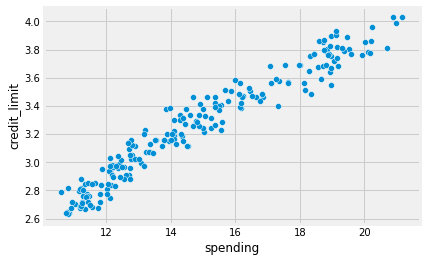

In [ ]:
# Bivariate analysis
sns.scatterplot(x= df['spending'], y =df['credit_limit'], data=df);

The spending and credit_limit have linear corelation 

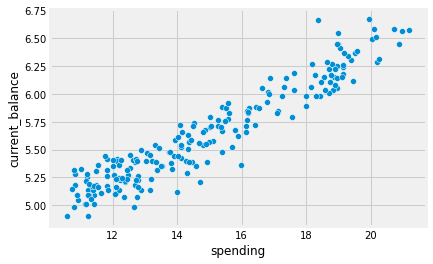

In [ ]:
# Bivariate analysis
sns.scatterplot(x= df['spending'], y =df['current_balance'], data=df);

Also the spending and current_balance have some linear corelation between them

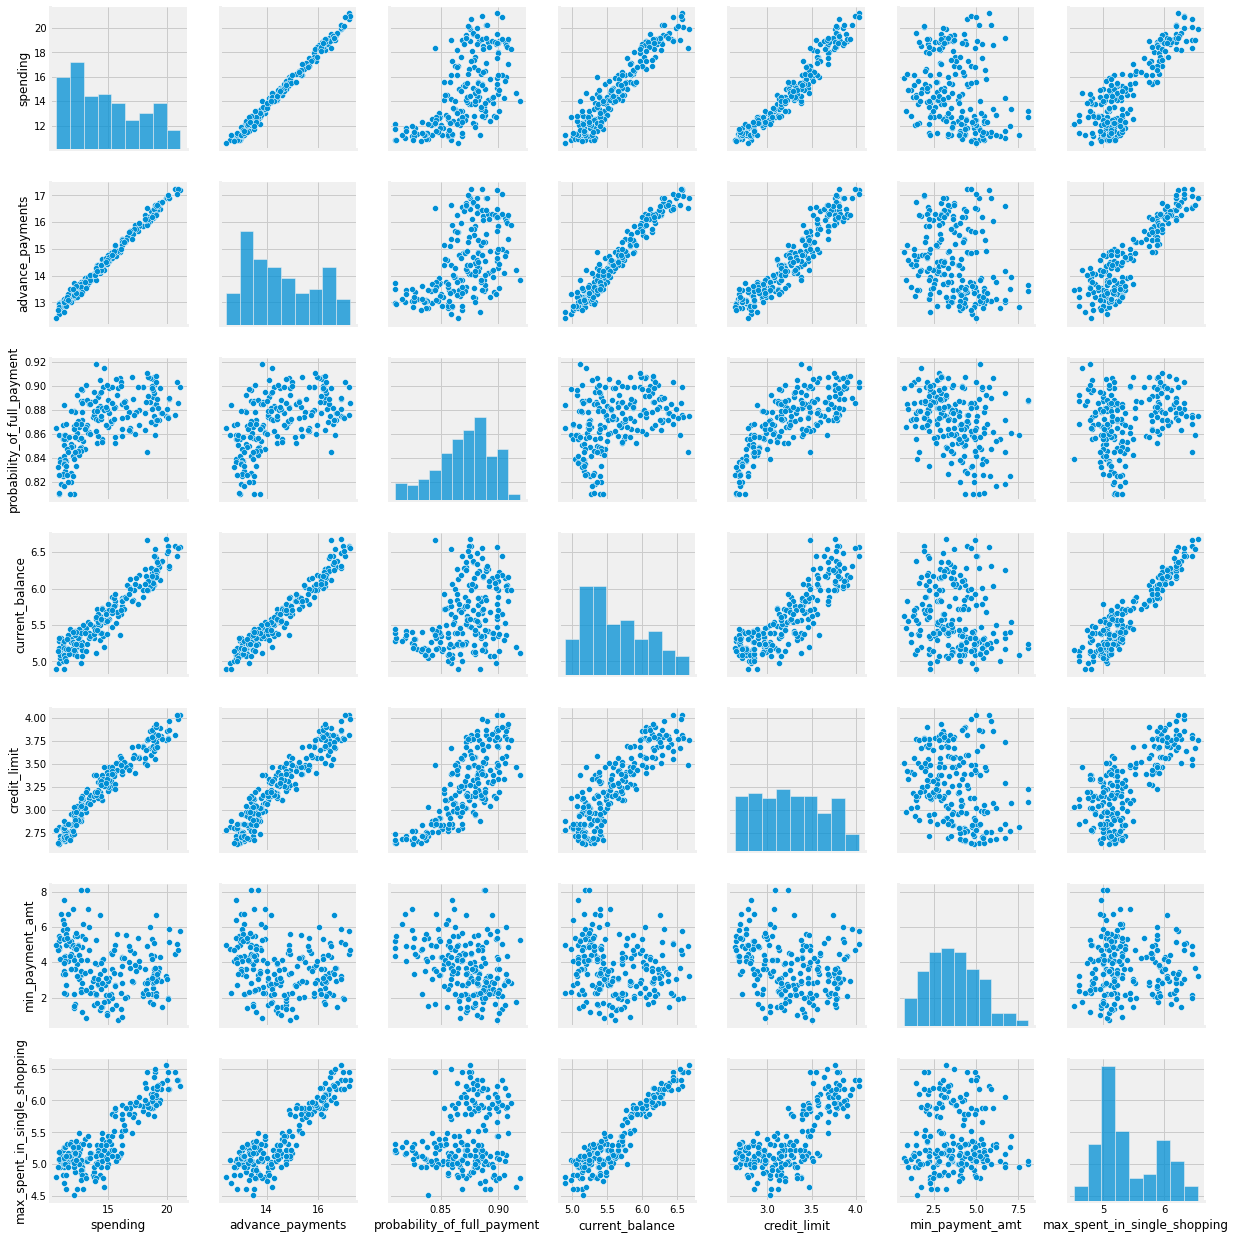

In [ ]:
# Multivariate Analysis
sns.pairplot(df);

By Visualising the pairplot of the dataset we can interpret that there are multicollinearity between the columns of the dataset i.e most of the features are corelated to each other

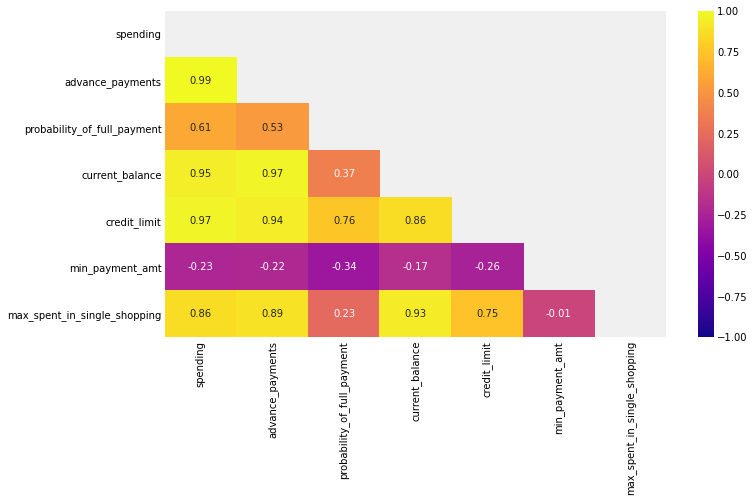

In [ ]:
# Heatmap Representation
plt.figure(figsize=(10,6))
matrix = np.triu(df.corr())
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='plasma', mask=matrix, vmax=1, vmin=-1);

From the above Heatmap we can interpret that the features are highly +ve corelated.

# Q1.2  Do you think scaling is necessary for clustering in this case? Justify

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df)
scaled_df

array([[ 1.75435461,  1.81196782,  0.177628  , ...,  1.33857863,
        -0.29862524,  2.3289982 ],
       [ 0.39358228,  0.25383997,  1.50507052, ...,  0.85823561,
        -0.24229198, -0.53858174],
       [ 1.41330028,  1.42819249,  0.505234  , ...,  1.317348  ,
        -0.22083168,  1.50910692],
       ...,
       [-0.2816364 , -0.30647202,  0.36483143, ..., -0.15287318,
        -1.32804867, -0.83023461],
       [ 0.43836719,  0.33827054,  1.23277462, ...,  0.60081421,
        -0.95718798,  0.07123789],
       [ 0.24889256,  0.45340314, -0.77966228, ..., -0.07325831,
        -0.70905334,  0.96047321]])

Yes will do scaling. Clustering algorithms such as K-means or hierarchical clustering do need feature scaling before they are fed to the algorithms. Since, clustering techniques use Euclidean Distance to form the cohorts, it will be wise. In clustering, we calculate the similarity between two examples by combining all the feature data for those examples into a numeric value. Combining feature data requires that the data have the same scale.

# Q 1.3 Apply hierarchical clustering to scaled data. Identify the number of optimum clusters using Dendrogram and briefly describe them

In [ ]:
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram, linkage,fcluster
from sklearn.cluster import AgglomerativeClustering
sns.set(context="notebook", palette="Spectral", style = 'darkgrid' ,font_scale =
1.5, color_codes=True)

In [ ]:
x = pd.DataFrame(scaled_df, columns=df.columns)

In [ ]:
x.head()

,spending,advance_payments,probability_of_full_payment,current_balance,credit_limit,min_payment_amt,max_spent_in_single_shopping
0,1.754355,1.811968,0.177628,2.367533,1.338579,-0.298625,2.328998
1,0.393582,0.253840,1.505071,-0.600744,0.858236,-0.242292,-0.538582
2,1.413300,1.428192,0.505234,1.401485,1.317348,-0.220832,1.509107
3,-1.384034,-1.227533,-2.571391,-0.793049,-1.639017,0.995699,-0.454961
4,1.082581,0.998364,1.198738,0.591544,1.155464,-1.092656,0.874813


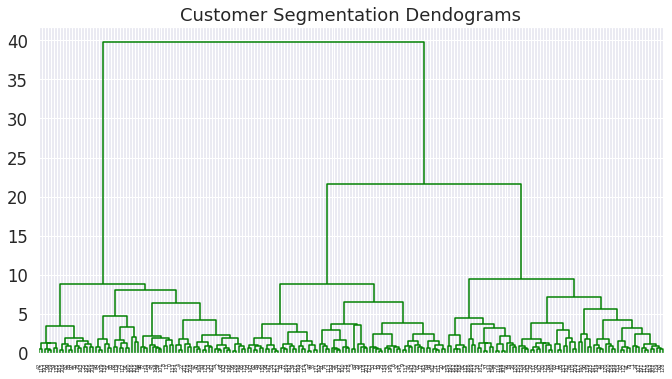

In [ ]:
plt.figure(figsize=(10,6))
plt.title("Customer Segmentation Dendograms")
Z = sch.dendrogram(sch.linkage(x, method = "ward", metric='euclidean') ,color_threshold=85.25)
plt.show()

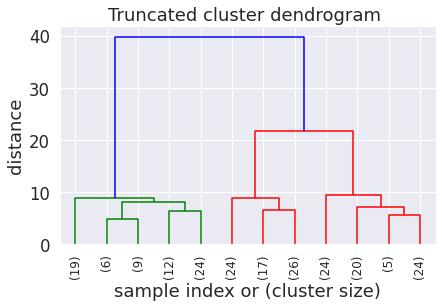

In [ ]:
Y = sch.linkage(scaled_df, method = "ward", metric='euclidean')
plt.title('Truncated cluster dendrogram ')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
sch.dendrogram(Y,truncate_mode='lastp', p=12, leaf_rotation=90,leaf_font_size=12)
plt.show()

In [ ]:
cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
Cluster_No =cluster.fit_predict(x)
print(Cluster_No)
df['Cluster'] = Cluster_No


[1 0 1 2 1 2 2 0 1 2 1 0 2 1 0 2 0 2 0 2 2 2 1 2 0 1 0 2 2 2 0 2 2 0 2 2 2
 2 2 1 1 0 1 1 2 2 0 1 1 1 2 1 1 1 1 1 2 2 2 1 0 2 2 0 0 1 1 0 1 2 0 2 1 1
 2 1 0 2 1 0 0 0 0 1 2 0 0 1 1 2 0 1 0 2 2 1 1 1 2 1 2 1 0 1 0 1 1 2 2 1 0
 0 1 2 2 1 0 0 2 1 0 2 2 2 0 0 1 2 0 0 2 0 0 1 2 1 1 2 1 0 0 0 2 2 0 2 1 2
 0 2 0 2 0 0 0 0 0 2 0 1 1 2 1 1 1 2 1 0 0 0 0 2 0 1 1 1 0 0 1 2 0 0 0 0 1
 1 0 0 0 2 0 0 2 1 0 1 1 2 1 2 0 1 0 2 1 0 1 0 1 0]


In [ ]:
df.head()

,spending,advance_payments,probability_of_full_payment,current_balance,credit_limit,min_payment_amt,max_spent_in_single_shopping,Cluster
0,19.94,16.92,0.875200,6.675,3.763,3.252,6.550,1
1,15.99,14.89,0.906400,5.363,3.582,3.336,5.144,0
2,18.95,16.42,0.882900,6.248,3.755,3.368,6.148,1
3,10.83,12.96,0.810588,5.278,2.641,5.182,5.185,2
4,17.99,15.86,0.899200,5.890,3.694,2.068,5.837,1


In [ ]:
df['Cluster'].value_counts().sort_values(ascending=False)

0    73
1    70
2    67
Name: Cluster, dtype: int64

In [ ]:
clust_profile1= df.groupby('Cluster').mean()
clust_profile1

,spending,advance_payments,probability_of_full_payment,current_balance,credit_limit,min_payment_amt,max_spent_in_single_shopping
Cluster,,,,,,,
0,14.199041,14.233562,0.879190,5.478233,3.226452,2.612181,5.086178
1,18.371429,16.145429,0.884400,6.158171,3.684629,3.639157,6.017371
2,11.872388,13.257015,0.848155,5.238940,2.848537,4.940302,5.122209


Final Conclusion:
1. After drawing the Horizontal considering the lowest height where three groups are joining in the above dendogram. I will take clusters 3 as I have to give promotional offers to my customers that's why I am dividng them into 3 groups (Ex: High, Medium and Low) so that I will be able to differentiate them in a propper order.


## Recomendation

Cluster 0(zero): Medium group of customer as they have medium spending as well 
                 as probability of full payment is also medium. So, Bnak can   
                 promote separate promotional offers to these customers to 
                 increase the spending limits. Bank can also increase the 
                 credit limit so that maximum spending in single shoping may 
                 also improve.


Cluster 1:       Higher in group of customer as they have higher spending as  
                 well as probability of full payment is also high and their 
                 maximum spending in single shoping is also high. So, Bnak 
                 can promote diffrerent promotional offers to these customers 
                 to increase the spending limits. Bank can also increase the 
                 credit limit so that maximum spending in single shoping may 
                 also improve.

Cluster 2:       Low in group of customer as they have lower spending as  
                 well as probability of full payment is also low and their 
                 maximum spending in single shoping is also low. So, Bnak 
                 can promote diffrerent promotional offers to these customers 
                 to increase the spending limits but bank needs to be carefull 
                 while increasing their spending limit as their probability of 
                 full payment is lower in the group .

# Q 1.4 Apply K-Means clustering on scaled data and determine optimum clusters. Apply elbow curve and silhouette score.

In [ ]:
from sklearn.cluster import KMeans

#### Elbow Method

In [ ]:
kmeans_data = df.copy()
wcss = []
for i in range(1, 10):
 kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
 kmeans.fit(scaled_df)
 # inertia method returns wcss for that model
 wcss.append(kmeans.inertia_)

In [ ]:
wcss

[1470.0,
 659.1474009548498,
 430.2984817512229,
 371.2217639268479,
 327.37117382097176,
 288.7437978983269,
 261.90949476512196,
 240.16126124284642,
 223.1596449528538]

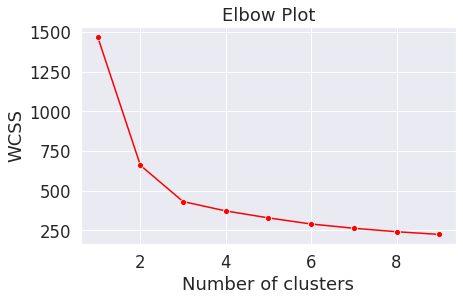

In [ ]:
# Elbow Method to find optimal number of clusters
sns.lineplot(range(1, 10), wcss,marker='o',color='red')
plt.title('Elbow Plot')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

It is not recomended here to find the optimal number of clusters by visualizing the Elbow Method. Therefore proceeding to see the silhouette score.

In [ ]:
from sklearn.metrics import silhouette_score
ss={1:0}
for i in range(2, 10):
 clusterer = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
 y=clusterer.fit_predict(scaled_df)
 # The higher (up to 1) the better
 s =silhouette_score(scaled_df, y )
 ss[i]=round(s,5)
 print("The Average Silhouette Score for {} clusters is {}".format(i,round(s,
5)))

The Average Silhouette Score for 2 clusters is 0.4656
The Average Silhouette Score for 3 clusters is 0.40081
The Average Silhouette Score for 4 clusters is 0.32944
The Average Silhouette Score for 5 clusters is 0.27959
The Average Silhouette Score for 6 clusters is 0.28898
The Average Silhouette Score for 7 clusters is 0.28104
The Average Silhouette Score for 8 clusters is 0.25179
The Average Silhouette Score for 9 clusters is 0.26163


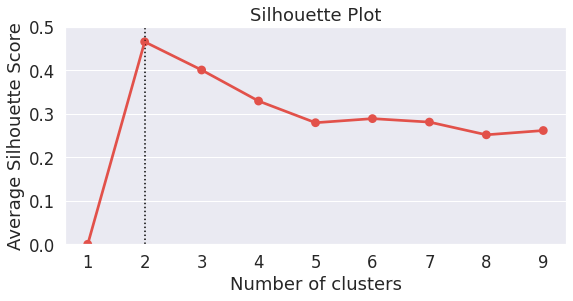

In [ ]:
maxkey= [key for key, value in ss.items() if value == max(ss.values())][0]
fig,ax = plt.subplots(figsize=(8,4))
sns.pointplot(list(ss.keys()),list(ss.values()))
plt.vlines(x=maxkey-1,ymax=0.5,ymin=0,linestyles='dotted')
ax.set(ylim=(0, 0.50))
ax.set_title('Silhouette Plot')
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Average Silhouette Score')
plt.show()

It is clear from above Figure that the maximum value of average silhouette score is achieved for k = 2, which,
therefore, is considered to be the optimum number of clusters for this data.

In [ ]:
 # Taking clusters 2 based on Silhouette Score
k_means = KMeans(n_clusters=3)
k_means = k_means.fit(scaled_df)
lables = k_means.labels_

In [ ]:
kmeans_df['clust_kmeans'] = lables

In [ ]:
kmeans_df.head()

,spending,advance_payments,probability_of_full_payment,current_balance,credit_limit,min_payment_amt,max_spent_in_single_shopping,clust_kmeans
0,19.94,16.92,0.8752,6.675,3.763,3.252,6.550,2
1,15.99,14.89,0.9064,5.363,3.582,3.336,5.144,1
2,18.95,16.42,0.8829,6.248,3.755,3.368,6.148,2
3,10.83,12.96,0.8099,5.278,2.641,5.182,5.185,0
4,17.99,15.86,0.8992,5.890,3.694,2.068,5.837,2


In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
silhouette_score(scaled_df, lables)

0.4008059221522216

In [ ]:
sil_width = silhouette_samples(scaled_df, lables)

In [ ]:
kmeans_df['sil_width'] = sil_width
kmeans_df.head()

,spending,advance_payments,probability_of_full_payment,current_balance,credit_limit,min_payment_amt,max_spent_in_single_shopping,clust_kmeans,sil_width
0,19.94,16.92,0.8752,6.675,3.763,3.252,6.550,2,0.573278
1,15.99,14.89,0.9064,5.363,3.582,3.336,5.144,1,0.365564
2,18.95,16.42,0.8829,6.248,3.755,3.368,6.148,2,0.637092
3,10.83,12.96,0.8099,5.278,2.641,5.182,5.185,0,0.515595
4,17.99,15.86,0.8992,5.890,3.694,2.068,5.837,2,0.360972


# Q 1.5 Describe cluster profiles for the clusters defined. Recommend different promotional strategies for different clusters.

#### Cluster Profiling for 3 cluster

In [ ]:
kmeans_df['clust_kmeans'].value_counts().sort_values(ascending=False)

0    72
1    71
2    67
Name: clust_kmeans, dtype: int64

In [ ]:
clust_profile=kmeans_df.groupby('clust_kmeans').mean()
clust_profile

,spending,advance_payments,probability_of_full_payment,current_balance,credit_limit,min_payment_amt,max_spent_in_single_shopping,sil_width
clust_kmeans,,,,,,,,
0,11.856944,13.247778,0.848253,5.231750,2.849542,4.742389,5.101722,0.399556
1,14.437887,14.337746,0.881597,5.514577,3.259225,2.707341,5.120803,0.338593
2,18.495373,16.203433,0.884210,6.175687,3.697537,3.632373,6.041701,0.468077


- Cluster 0: In this cluster the spending by the customers is high, maximum spending in single shopping is also high and their credit limit is also high.

- Cluster 1: In this cluster the spending by the customers is low, maximum spending in single shopping is also low and thier credit limit is also low.

# Recommendations

1. The customers in Cluster 0(zero) has highest spending as well as maximum spending in single shoping is also high. So, Bnak can promote various promotional offers to these customers to increase the spending limits and also banks needs to carefull while giving offers so that they may not default.


2. Customers in Cluster 1 has low spending as well as maximum spending in single shoping is also low. Bank need to give different promotional officers  with diffrent strategy so that they may incearse their spending limit.

# Problem 2: CART-RF-ANN

#### An Insurance firm providing tour insurance is facing higher claim frequency. The management decides to collect data from the past few years. You are assigned the task to make a model which predicts the claim status and provide recommendations to management. Use CART, RF & ANN and compare the models' performances in train and test sets.

## Q2.1 Data Ingestion: Read the dataset. Do the descriptive statistics and do null value condition check, write an inference on it.

# CART

#### Loading the Dataset

In [ ]:
mydata = pd.read_csv('/content/drive/MyDrive/Data Science/Project Data Mining/insurance_part2_data.csv')

In [ ]:
df1 = mydata.copy(deep=True)
df1.head()

,Age,Agency_Code,Type,Claimed,Commision,Channel,Duration,Sales,Product Name,Destination
0,48,C2B,Airlines,No,0.70,Online,7,2.51,Customised Plan,ASIA
1,36,EPX,Travel Agency,No,0.00,Online,34,20.00,Customised Plan,ASIA
2,39,CWT,Travel Agency,No,5.94,Online,3,9.90,Customised Plan,Americas
3,36,EPX,Travel Agency,No,0.00,Online,4,26.00,Cancellation Plan,ASIA
4,33,JZI,Airlines,No,6.30,Online,53,18.00,Bronze Plan,ASIA


In [ ]:
df1.shape

(3000, 10)

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Age           3000 non-null   int64  
 1   Agency_Code   3000 non-null   object 
 2   Type          3000 non-null   object 
 3   Claimed       3000 non-null   object 
 4   Commision     3000 non-null   float64
 5   Channel       3000 non-null   object 
 6   Duration      3000 non-null   int64  
 7   Sales         3000 non-null   float64
 8   Product Name  3000 non-null   object 
 9   Destination   3000 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 234.5+ KB


In [ ]:
df1.describe()

,Age,Commision,Duration,Sales
count,3000.000000,3000.000000,3000.000000,3000.000000
mean,38.091000,14.529203,70.001333,60.249913
std,10.463518,25.481455,134.053313,70.733954
min,8.000000,0.000000,-1.000000,0.000000
25%,32.000000,0.000000,11.000000,20.000000
50%,36.000000,4.630000,26.500000,33.000000
75%,42.000000,17.235000,63.000000,69.000000
max,84.000000,210.210000,4580.000000,539.000000


By describing the dataset we can see there is some -ve value in Duration columns which is not possible so we need to fix it.

### Exploratory Data Analysis

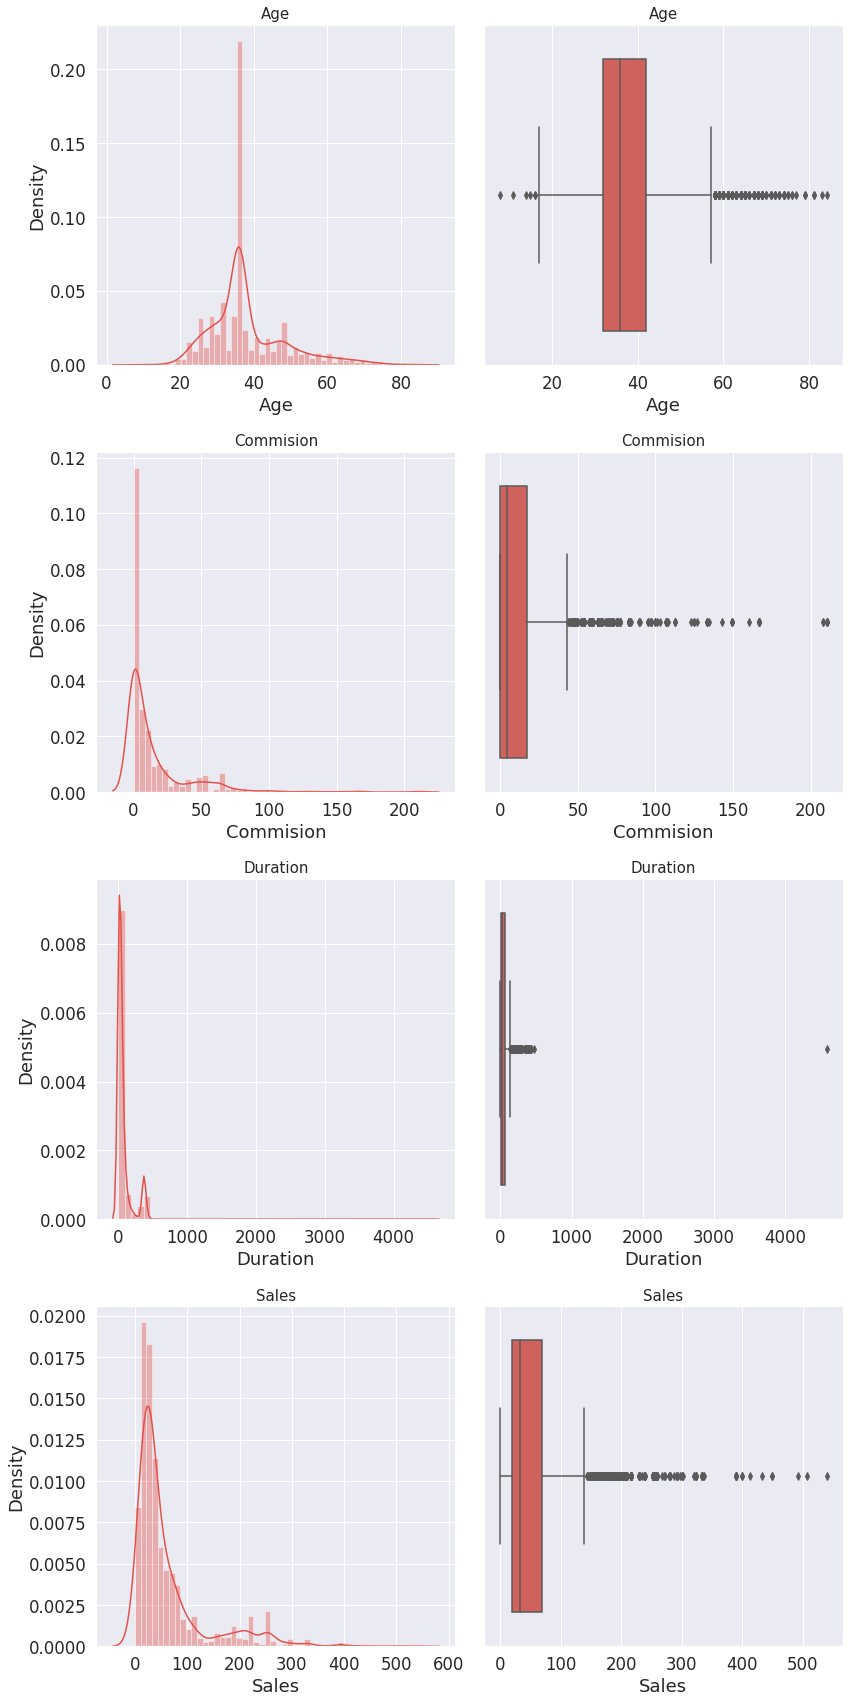

In [ ]:
# Univariate Analysis
fig, axes = plt.subplots(nrows=4, ncols=2)
fig.set_size_inches(12,24)
a = sns.distplot(df1['Age'], ax = axes[0][0]);
a.set_title('Age', fontsize = 15)

a = sns.boxplot(df1['Age'], ax = axes[0][1])
a.set_title('Age', fontsize = 15)

a = sns.distplot(df1['Commision'], ax = axes[1][0])
a.set_title('Commision', fontsize = 15)

a = sns.boxplot(df1['Commision'], ax = axes[1][1])
a.set_title('Commision', fontsize = 15)

a = sns.distplot(df1['Duration'], ax = axes[2][0]);
a.set_title('Duration', fontsize = 15)

a = sns.boxplot(df1['Duration'], ax = axes[2][1])
a.set_title('Duration', fontsize = 15)

a = sns.distplot(df1['Sales'], ax = axes[3][0])
a.set_title('Sales', fontsize = 15)

a = sns.boxplot(df1['Sales'], ax = axes[3][1])
a.set_title('Sales', fontsize = 15)
plt.tight_layout()

plt.show()

Con1: Variable Age is normaly distributed and there is some upper and lower outliers which needs te be treated

con2: Variable Commision is right skwed and there is some upper and outliers which needs te be treated

con3: Variable Duration is slightly right skwed and there is some upper and outliers which needs te be treated

con4: Variable Sales is right skwed and there is some upper and outliers which needs te be treated

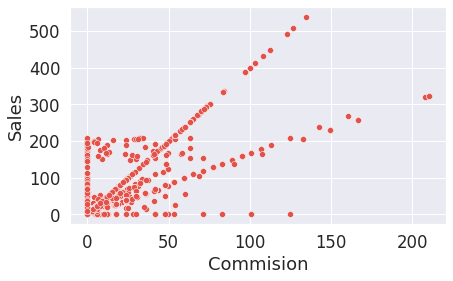

In [ ]:
# Bivariate analysis
sns.scatterplot(x= df1['Commision'], y =df1['Sales'], data=df1);

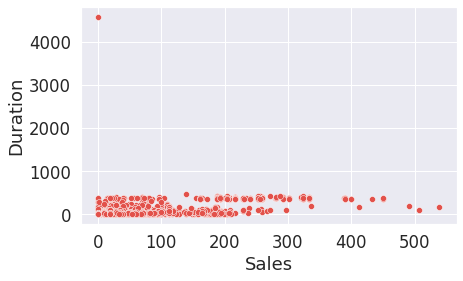

In [ ]:
# Bivariate analysis
sns.scatterplot(x= df1['Sales'], y =df1['Duration'], data=df1);

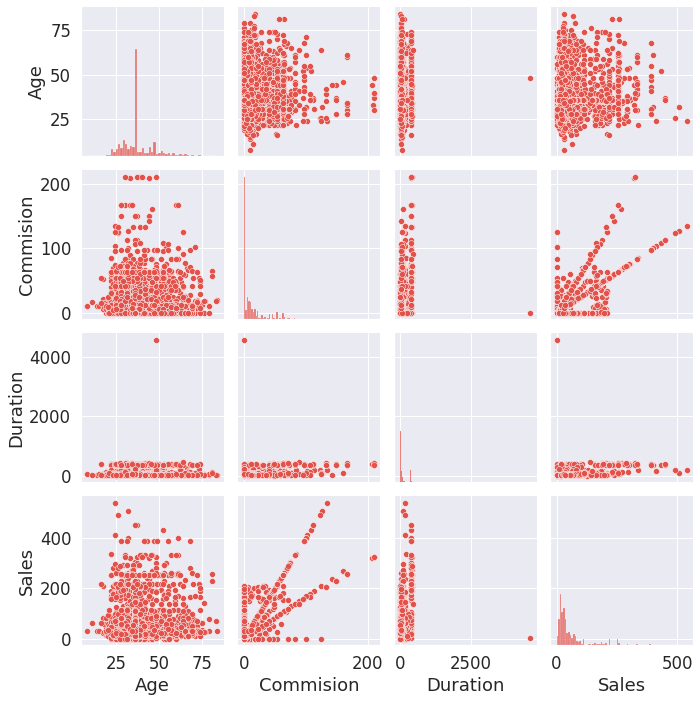

In [ ]:
# Multivariate Analysis
sns.pairplot(df1);

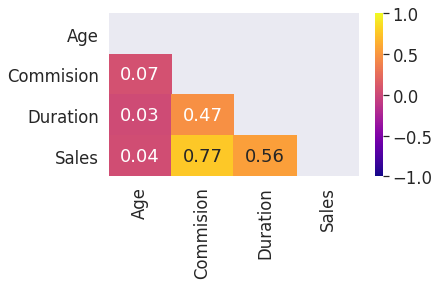

In [ ]:
# Heatmap Representation
plt.figure(figsize=(5,3))
matrix = np.triu(df1.corr())
sns.heatmap(df1.corr(), annot=True, fmt='.2f', cmap='plasma', mask=matrix, vmax=1, vmin=-1);

From above heatmap we can interpret that Commision and Sales are highly +ve corelated and Duration and Sales are also positively corelated

In [ ]:
df1['Duration'].value_counts()

 8       83
 5       82
 6       81
 10      81
 11      81
         ..
 466      1
 421      1
-1        1
 119      1
 4580     1
Name: Duration, Length: 257, dtype: int64

There is one -ve value in Duration columns so replacing it with Nan values

In [ ]:
## Replacing -1 as Nan in Duration variable
df1.Duration.replace(to_replace= -1 , value=np.nan, inplace=True)

In [ ]:
df1.isnull().sum()

Age             0
Agency_Code     0
Type            0
Claimed         0
Commision       0
Channel         0
Duration        1
Sales           0
Product Name    0
Destination     0
dtype: int64

In [ ]:
df1.dropna(inplace=True)

In [ ]:
df1.isnull().sum().any()

False

In [ ]:
df1.duplicated().sum()

139

In [ ]:
df1.drop_duplicates(inplace=True)
df1.duplicated().sum()

0

In [ ]:
# Tacking a cpoy of the dataset
insurance = df1.copy()
insurance.reset_index(inplace = True)
insurance.head()

,index,Age,Agency_Code,Type,Claimed,Commision,Channel,Duration,Sales,Product Name,Destination
0,0,48,C2B,Airlines,No,0.70,Online,7.0,2.51,Customised Plan,ASIA
1,1,36,EPX,Travel Agency,No,0.00,Online,34.0,20.00,Customised Plan,ASIA
2,2,39,CWT,Travel Agency,No,5.94,Online,3.0,9.90,Customised Plan,Americas
3,3,36,EPX,Travel Agency,No,0.00,Online,4.0,26.00,Cancellation Plan,ASIA
4,4,33,JZI,Airlines,No,6.30,Online,53.0,18.00,Bronze Plan,ASIA


In [ ]:
insurance.isnull().sum()

index           0
Age             0
Agency_Code     0
Type            0
Claimed         0
Commision       0
Channel         0
Duration        0
Sales           0
Product Name    0
Destination     0
dtype: int64

### Checking for outliers 

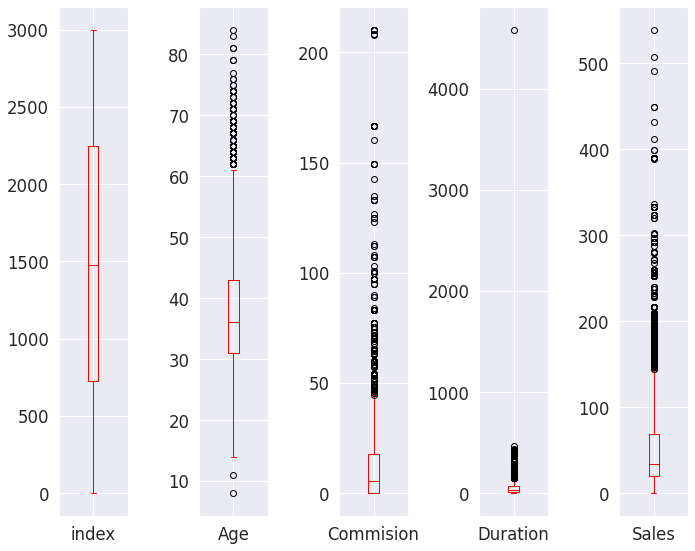

In [ ]:
insurance.plot(kind = 'box', subplots=True, color='red', figsize=(10,8))
plt.tight_layout()
plt.show()

In [ ]:
# def out_limit(col):
#   Q1, Q3 = col.quantile([0.25,0.75])
#   IQR = Q3 - Q1
#   lower_range = Q1 - (1.5*IQR)
#   upper_range = Q3 + (1.5*IQR)
#   return lower_range, upper_range

In [ ]:
# ol_col = ['Age', 'Commision', 'Duration','Sales', ]

# for col in ol_col:
#   lr, ur = out_limit(insurance[col])
#   insurance[col] = np.where(insurance[col] < lr, lr, insurance[col])
#   insurance[col] = np.where(insurance[col] > ur, ur, insurance[col])

In [ ]:
# insurance.plot(kind = 'box', subplots=True, color='red', figsize=(10,8))
# plt.tight_layout()
# plt.show()

Conclusion: 

I have removed the -ve value of Duration variable with Nan value and them performed dropna function to impute the Nan value.

There are 139 Duplicate values in the dataset which I have droped by using command drop_duplicated. 

Finally I have taken a copy of dataset name insurance and reset the index of dataset.

# Q 2.2 Data Split: Split the data into test and train, build classification model CART, Random Forest, Artificial Neural Network

In [ ]:
insurance = insurance.drop('index', axis=1)
insurance.head()

,Age,Agency_Code,Type,Claimed,Commision,Channel,Duration,Sales,Product Name,Destination
0,48,C2B,Airlines,No,0.70,Online,7.0,2.51,Customised Plan,ASIA
1,36,EPX,Travel Agency,No,0.00,Online,34.0,20.00,Customised Plan,ASIA
2,39,CWT,Travel Agency,No,5.94,Online,3.0,9.90,Customised Plan,Americas
3,36,EPX,Travel Agency,No,0.00,Online,4.0,26.00,Cancellation Plan,ASIA
4,33,JZI,Airlines,No,6.30,Online,53.0,18.00,Bronze Plan,ASIA


In [ ]:
# Checking unique counts of all the objects
print('Agency_Code \n', insurance.Agency_Code.value_counts())
print('\n')
print('Type \n', insurance.Type.value_counts())
print('\n')
print('Claimed \n', insurance.Claimed.value_counts())
print('\n')
print('Commision \n', insurance.Commision.value_counts())


Agency_Code 
 EPX    1238
C2B     913
CWT     471
JZI     238
Name: Agency_Code, dtype: int64


Type 
 Travel Agency    1709
Airlines         1151
Name: Type, dtype: int64


Claimed 
 No     1946
Yes     914
Name: Claimed, dtype: int64


Commision 
 0.00     1239
23.76      61
54.00      59
63.21      59
7.70       57
         ... 
67.75       1
17.29       1
18.13       1
49.40       1
0.18        1
Name: Commision, Length: 324, dtype: int64


In [ ]:
# converting the variables into codes
for feature in insurance.columns:
  if insurance[feature].dtypes == 'object':
    print('\n')
    print('feature:', feature)
    print(pd.Categorical(insurance[feature].unique()))
    print(pd.Categorical(insurance[feature].unique()).codes)
    insurance[feature] = pd.Categorical(insurance[feature]).codes




feature: Agency_Code
['C2B', 'EPX', 'CWT', 'JZI']
Categories (4, object): ['C2B', 'CWT', 'EPX', 'JZI']
[0 2 1 3]


feature: Type
['Airlines', 'Travel Agency']
Categories (2, object): ['Airlines', 'Travel Agency']
[0 1]


feature: Claimed
['No', 'Yes']
Categories (2, object): ['No', 'Yes']
[0 1]


feature: Channel
['Online', 'Offline']
Categories (2, object): ['Offline', 'Online']
[1 0]


feature: Product Name
['Customised Plan', 'Cancellation Plan', 'Bronze Plan', 'Silver Plan', 'Gold Plan']
Categories (5, object): ['Bronze Plan', 'Cancellation Plan', 'Customised Plan', 'Gold Plan',
                         'Silver Plan']
[2 1 0 4 3]


feature: Destination
['ASIA', 'Americas', 'EUROPE']
Categories (3, object): ['ASIA', 'Americas', 'EUROPE']
[0 1 2]


In [ ]:
insurance.head()

,Age,Agency_Code,Type,Claimed,Commision,Channel,Duration,Sales,Product Name,Destination
0,48,0,0,0,0.70,1,7.0,2.51,2,0
1,36,2,1,0,0.00,1,34.0,20.00,2,0
2,39,1,1,0,5.94,1,3.0,9.90,2,1
3,36,2,1,0,0.00,1,4.0,26.00,1,0
4,33,3,0,0,6.30,1,53.0,18.00,0,0


In [ ]:
insurance.isnull().sum().any()

False

In [ ]:
# Checking the class of target variable
insurance['Claimed'].value_counts(normalize = True)

0    0.68042
1    0.31958
Name: Claimed, dtype: float64

### Extracting the target column into separate vectors for training set and test set


In [ ]:
x = insurance.drop('Claimed', axis=1)
y = insurance.pop('Claimed')

### Splitting data into training and testing set

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, train_labels, test_labels = train_test_split(x, y, test_size=0.30, random_state = 0)

In [ ]:
# Checking the shape
print('x_train',x_train.shape)
print('x_test',x_test.shape)
print('train_labels',train_labels.shape)
print('test_labels',test_labels.shape)

x_train (2002, 9)
x_test (858, 9)
train_labels (2002,)
test_labels (858,)


### Building a Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier(criterion ='gini')

In [ ]:
# Fitting the model
dt_model.fit(x_train, train_labels)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
# Visualizing the tree for pruning(Using: webgraphviz.com)
from sklearn import tree 
train_char_label = ['No', 'Yes']
tree_file = open('sample_data:\tree.file.dot','w')
dot_data = tree.export_graphviz(dt_model, out_file= tree_file,
                                feature_names = list(x_train),
                                class_names = list(train_char_label))

tree_file.close()


In [ ]:
dt_model.feature_importances_

array([0.17818622, 0.19995692, 0.        , 0.07731061, 0.00776342,
       0.251713  , 0.23155064, 0.02886827, 0.02465091])

In [ ]:
# Variable Importance
print(pd.DataFrame(dt_model.feature_importances_, columns= ['Impt'], index=x_train.columns).sort_values('Impt', ascending = False))

                  Impt
Duration      0.251713
Sales         0.231551
Agency_Code   0.199957
Age           0.178186
Commision     0.077311
Product Name  0.028868
Destination   0.024651
Channel       0.007763
Type          0.000000


In [ ]:
# Predicting the test Data
y_predict = dt_model.predict(x_test)

In [ ]:
y_predict.shape

(858,)

In [ ]:
print(y_predict)

[0 0 1 1 1 1 1 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 1 0 1 0 0 0 0 0 1 0 1 0 1 1 0
 0 1 0 0 0 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 1 1 1 0 1 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 1 0 1 1 0 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0
 1 1 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1 0 1 0 0 1 1 1 0 1 1 1 0 1 1 0 0 1 0 1 1
 0 1 1 1 0 1 0 0 1 1 1 0 1 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 1 1 1 1 0 0 0 1 0 0 0 0
 1 0 0 0 1 0 1 1 0 1 1 0 1 0 1 0 0 1 0 1 1 1 0 1 0 0 0 0 1 0 0 1 0 1 0 0 0
 1 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 1 0 0 0 0 1 0 0 0 0
 1 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 0
 0 0 1 1 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 0 1 0 1 0 0 1
 1 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 1 0 0 1 1 1 0 0 0 0 0 1 1 1 0 1 0 1 0 0 1
 0 1 0 0 1 0 1 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 1 1 1 0 1
 1 0 1 0 1 1 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 1 0 1 0 1 0 0 0 0
 0 0 0 0 0 1 0 1 0 0 0 0 

## Regularising the tree

In [ ]:
reg_dt_model = DecisionTreeClassifier(criterion='gini',
                                      max_depth = 6,
                                      min_samples_leaf = 50,
                                      min_samples_split = 150)

reg_dt_model.fit(x_train, train_labels)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=50, min_samples_split=150,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

## Generating New Tree

In [ ]:
reg_tree = open('sample_data:\reg_tree.dot', 'w')
reg_tree_file = tree.export_graphviz(reg_dt_model, out_file=reg_tree, feature_names=list(x_train), class_names=list(train_char_label))
reg_tree.close()
reg_tree_file

In [ ]:
print(pd.DataFrame(reg_dt_model.feature_importances_, columns=['Impt'], index=x_train.columns).sort_values('Impt',ascending =False))

                  Impt
Agency_Code   0.600758
Sales         0.288269
Commision     0.037784
Product Name  0.035883
Duration      0.018690
Age           0.018615
Type          0.000000
Channel       0.000000
Destination   0.000000


### Predicting on Training and Testing Data

In [ ]:
ytrain_predict = reg_dt_model.predict(x_train)
ytest_predict = reg_dt_model.predict(x_test)

In [ ]:
# Getting the predicted probabilities for test data
reg_dt_model.predict_proba(x_test)

array([[0.80555556, 0.19444444],
       [1.        , 0.        ],
       [0.34666667, 0.65333333],
       ...,
       [0.46923077, 0.53076923],
       [0.47142857, 0.52857143],
       [0.87323944, 0.12676056]])

## Q 2.3 Performance Metrics: Check the performance of Predictions on Train and Test sets using Accuracy, Confusion Matrix, Plot ROC curve and get ROC_AUC score for each model

In [ ]:
import matplotlib.pyplot as plt


#### AUC and ROC for the Traning Data

AUC:  0.839


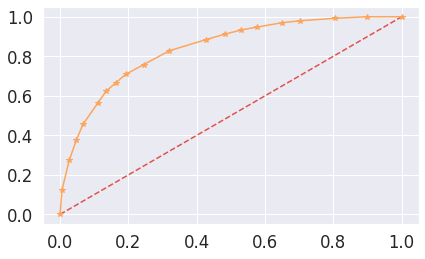

In [ ]:
prob = reg_dt_model.predict_proba(x_train)
prob = prob[:,1]
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
auc = roc_auc_score(train_labels, prob)
print('AUC: % .3f'% auc)
fpr, tpr, threshold = roc_curve(train_labels, prob)
plt.plot([0,1], [0,1], linestyle = '--')
plt.plot(fpr, tpr, marker = '*'); 


#### AOC and ROC for testing Data

AUC:0.753


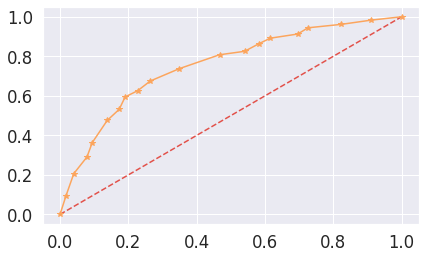

In [ ]:
prob= reg_dt_model.predict_proba(x_test)
prob = prob [:,1]
auc = roc_auc_score(test_labels, prob)
fpr, tpr, threshold = roc_curve(test_labels, prob)
print('AUC:%.3f'% auc)
plt.plot([0,1], [0,1], linestyle='--')
plt.plot(fpr, tpr, marker = '*');

### Confusion Matrix and classification report for the training and testing data

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

In [ ]:
print(confusion_matrix(ytrain_predict, train_labels))

[[1188  236]
 [ 186  392]]


In [ ]:
print(classification_report(ytrain_predict, train_labels))

              precision    recall  f1-score   support

           0       0.86      0.83      0.85      1424
           1       0.62      0.68      0.65       578

    accuracy                           0.79      2002
   macro avg       0.74      0.76      0.75      2002
weighted avg       0.80      0.79      0.79      2002



In [ ]:
print(confusion_matrix(ytest_predict, test_labels))

[[473 134]
 [ 99 152]]


In [ ]:
print(classification_report(ytest_predict, test_labels))

              precision    recall  f1-score   support

           0       0.83      0.78      0.80       607
           1       0.53      0.61      0.57       251

    accuracy                           0.73       858
   macro avg       0.68      0.69      0.68       858
weighted avg       0.74      0.73      0.73       858



## Conclusion

Accuracy on the Training Data: 79%  
Accuracy on the Test Data: 73%

AUC on the Training Data: 84%  
AUC on the Test: 75%

Accuracy, AUC, Precision and Recall for test data is slightly lower with training data.  
This proves no overfitting or underfitting has happened, and overall the model is a good model for classification

Agency_code, sales and commision (in same order of preference) are the most important variables in determining in terms of claiming.

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfcl = RandomForestClassifier(n_estimators=400, criterion='gini', max_depth=6, max_features=4, min_samples_leaf=10, min_samples_split=30, oob_score=True)

In [ ]:
rfcl.fit(x_train, train_labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6, max_features=4,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=30,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
rfcl.oob_score_

0.7882117882117882

In [ ]:
from sklearn.model_selection import GridSearchCV
rfcl = RandomForestClassifier(random_state=0)
grid_param = {'max_depth':[5,6,7],
              'max_features':[3,4,5],
              'min_samples_leaf':[5,10,20],
              'min_samples_split':[15,30,60],
              'n_estimators':[300,400,500]}

In [ ]:
 grid_search = GridSearchCV(rfcl, param_grid=grid_param, cv=5)

In [ ]:
grid_search.fit(x_train, train_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=0,
                                   

In [ ]:
grid_search.best_params_

{'max_depth': 7,
 'max_features': 5,
 'min_samples_leaf': 10,
 'min_samples_split': 15,
 'n_estimators': 400}

In [ ]:
best_grid = grid_search.best_estimator_

### Predicting on Training and Testing Data

In [ ]:
ytrain_predict = best_grid.predict(x_train)
ytest_predict = best_grid.predict(x_test)

## Q2.3 Performance Metrics: Check the performance of Predictions on Train and Test sets using Accuracy, Confusion Matrix, Plot ROC curve and get ROC_AUC score for each model

AUC:0.880


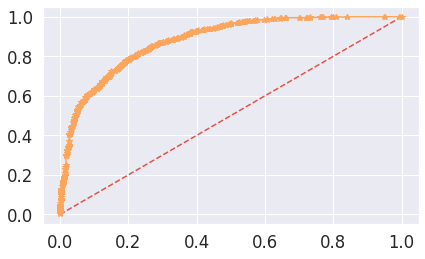

In [ ]:
# AUC-ROC curve for Training Data
prob = best_grid.predict_proba(x_train)
prob = prob [:,1]
auc = roc_auc_score(train_labels, prob)
fpr, tpr, threshold = roc_curve(train_labels, prob)
plt.plot([0,1],[0,1], linestyle= '--')
plt.plot(fpr, tpr, marker = '*');
print('AUC:%.3f' % auc)


AUC:0.772


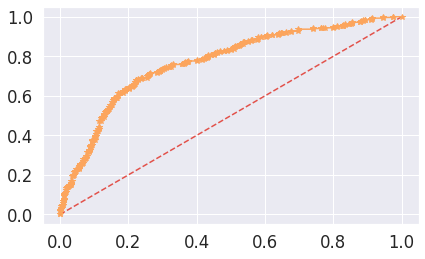

In [ ]:
# AUC-ROC curve for Testing Data
prob = best_grid.predict_proba(x_test)
prob = prob [:,1]
auc = roc_auc_score(test_labels, prob)
fpr, tpr, threshold = roc_curve(test_labels, prob)
plt.plot([0,1],[0,1], linestyle= '--')
plt.plot(fpr, tpr, marker = '*');
print('AUC:%.3f' % auc)


### Confusion Matrix and classification report for the training and testing data


In [ ]:
# confusion matrix for training data
print(confusion_matrix(ytrain_predict, train_labels))

[[1236  231]
 [ 138  397]]


In [ ]:
# confusion matrix for test data
print(confusion_matrix(ytest_predict, test_labels))

[[489 128]
 [ 83 158]]


In [ ]:
print(classification_report(ytrain_predict,train_labels))

              precision    recall  f1-score   support

           0       0.90      0.84      0.87      1467
           1       0.63      0.74      0.68       535

    accuracy                           0.82      2002
   macro avg       0.77      0.79      0.78      2002
weighted avg       0.83      0.82      0.82      2002



In [ ]:
print(classification_report(ytest_predict,test_labels))

              precision    recall  f1-score   support

           0       0.85      0.79      0.82       617
           1       0.55      0.66      0.60       241

    accuracy                           0.75       858
   macro avg       0.70      0.72      0.71       858
weighted avg       0.77      0.75      0.76       858



Accuracy on the Training Data: 82%  
Accuracy on the Test Data: 75%

AUC on the Training Data: 88%  
AUC on the Test: 77%

Accuracy, AUC, Precision and Recall for test data is slightly in lower side as compare with training data.  
This proves no overfitting or underfitting has happened, and overall the model is a satisfactory model for classification

## Artificial Neural Network

In [ ]:
# Extracting the Dataset
df2 = mydata.copy(deep=True)
df2.head()

,Age,Agency_Code,Type,Claimed,Commision,Channel,Duration,Sales,Product Name,Destination
0,48,C2B,Airlines,No,0.70,Online,7,2.51,Customised Plan,ASIA
1,36,EPX,Travel Agency,No,0.00,Online,34,20.00,Customised Plan,ASIA
2,39,CWT,Travel Agency,No,5.94,Online,3,9.90,Customised Plan,Americas
3,36,EPX,Travel Agency,No,0.00,Online,4,26.00,Cancellation Plan,ASIA
4,33,JZI,Airlines,No,6.30,Online,53,18.00,Bronze Plan,ASIA


In [ ]:
df2.shape

(3000, 10)

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Age           3000 non-null   int64  
 1   Agency_Code   3000 non-null   object 
 2   Type          3000 non-null   object 
 3   Claimed       3000 non-null   object 
 4   Commision     3000 non-null   float64
 5   Channel       3000 non-null   object 
 6   Duration      3000 non-null   int64  
 7   Sales         3000 non-null   float64
 8   Product Name  3000 non-null   object 
 9   Destination   3000 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 234.5+ KB


In [ ]:
df2.describe()

,Age,Commision,Duration,Sales
count,3000.000000,3000.000000,3000.000000,3000.000000
mean,38.091000,14.529203,70.001333,60.249913
std,10.463518,25.481455,134.053313,70.733954
min,8.000000,0.000000,-1.000000,0.000000
25%,32.000000,0.000000,11.000000,20.000000
50%,36.000000,4.630000,26.500000,33.000000
75%,42.000000,17.235000,63.000000,69.000000
max,84.000000,210.210000,4580.000000,539.000000


In [ ]:
## Replacing -1 as Nan in Duration variable
df2.Duration.replace(to_replace= -1 , value=np.nan, inplace=True)
df2.isnull().sum().any()

True

In [ ]:
df2.dropna(inplace=True)

In [ ]:
df2.duplicated().sum()

139

In [ ]:
df2.drop_duplicates(inplace=True)

In [ ]:
df2.duplicated().sum()

0

In [ ]:
# Tacking a cpoy of the dataset
ANN_df2 = df2.copy()
ANN_df2.reset_index(inplace = True)
ANN_df2.head()

,index,Age,Agency_Code,Type,Claimed,Commision,Channel,Duration,Sales,Product Name,Destination
0,0,48,C2B,Airlines,No,0.70,Online,7.0,2.51,Customised Plan,ASIA
1,1,36,EPX,Travel Agency,No,0.00,Online,34.0,20.00,Customised Plan,ASIA
2,2,39,CWT,Travel Agency,No,5.94,Online,3.0,9.90,Customised Plan,Americas
3,3,36,EPX,Travel Agency,No,0.00,Online,4.0,26.00,Cancellation Plan,ASIA
4,4,33,JZI,Airlines,No,6.30,Online,53.0,18.00,Bronze Plan,ASIA


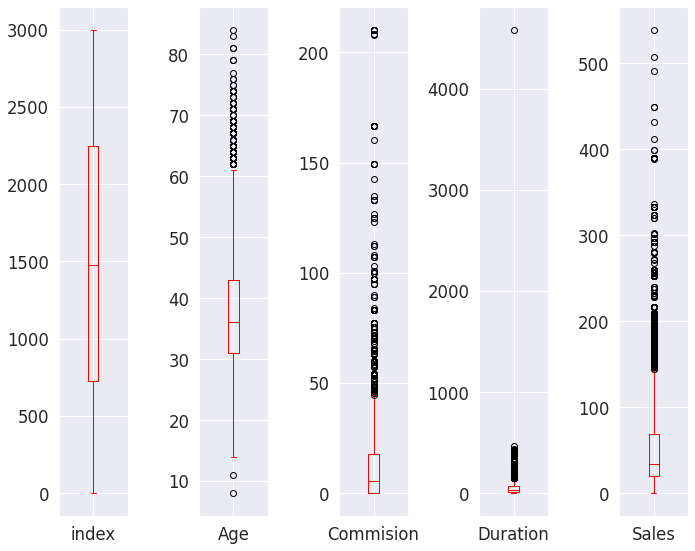

In [ ]:
ANN_df2.plot(kind='box', subplots=True, figsize=(10,8),color='red')
plt.tight_layout()
plt.show()

In [ ]:
def out_limit(col):
  Q1, Q3 = col.quantile([0.25,0.75])
  IQR = Q3 - Q1
  lower_range = Q1 - (1.5*IQR)
  upper_range = Q3 + (1.5*IQR)
  return lower_range, upper_range

In [ ]:
ol_col = ['Age', 'Commision', 'Duration','Sales', ]

for col in ol_col:
  lr, ur = out_limit(ANN_df2[col])
  ANN_df2[col] = np.where(ANN_df2[col] < lr, lr, ANN_df2[col])
  ANN_df2[col] = np.where(ANN_df2[col] > ur, ur, ANN_df2[col])

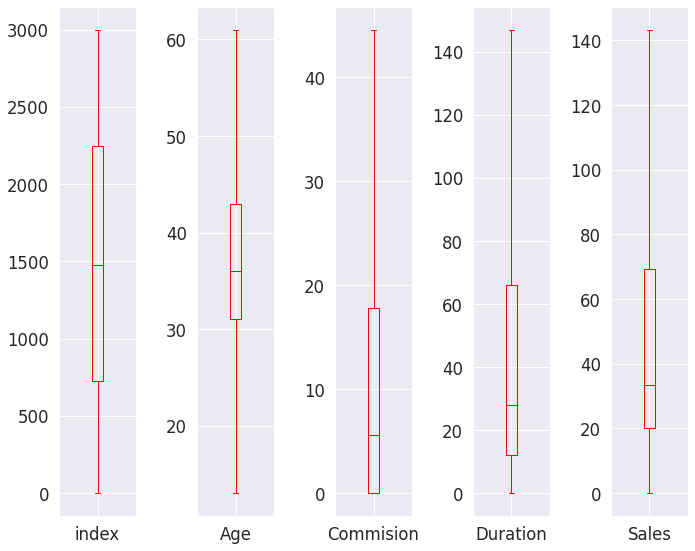

In [ ]:
ANN_df2.plot(kind='box', subplots=True, figsize=(10,8),color='red')
plt.tight_layout()
plt.show()

In [ ]:
# converting the variables into codes
for feature in ANN_df2.columns:
  if ANN_df2[feature].dtypes == 'object':
     ANN_df2[feature] = pd.Categorical(ANN_df2[feature]).codes


In [ ]:
ANN_df2.head()

,index,Age,Agency_Code,Type,Claimed,Commision,Channel,Duration,Sales,Product Name,Destination
0,0,48.0,0,0,0,0.70,1,7.0,2.51,2,0
1,1,36.0,2,1,0,0.00,1,34.0,20.00,2,0
2,2,39.0,1,1,0,5.94,1,3.0,9.90,2,1
3,3,36.0,2,1,0,0.00,1,4.0,26.00,1,0
4,4,33.0,3,0,0,6.30,1,53.0,18.00,0,0


In [ ]:
ANN_df2['Claimed'].value_counts(normalize=True)

0    0.68042
1    0.31958
Name: Claimed, dtype: float64

### Splitting the Data into Training and Testing set

In [ ]:
x = ANN_df2.drop('Claimed', axis=1)
y = ANN_df2.pop('Claimed')

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, train_labels, test_labels = train_test_split(x, y, test_size=0.30, random_state = 0)

In [ ]:
# Checking the shape
print('x_train',x_train.shape)
print('x_test',x_test.shape)
print('train_labels',train_labels.shape)
print('test_labels',test_labels.shape)

x_train (2002, 10)
x_test (858, 10)
train_labels (2002,)
test_labels (858,)


#### Sacling the Training and Testing Data for Neural Network

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [ ]:
# Scaling the Traing Data
x_train = scaler.fit_transform(x_train)
x_train

array([[ 0.77319032, -0.71282796, -0.27851557, ..., -0.27344823,
         0.26110178, -0.44899583],
       [ 1.64403437, -0.19718929,  0.71717759, ..., -0.96612451,
        -0.52495201, -0.44899583],
       [-0.17629568, -0.19718929,  0.71717759, ..., -0.82571715,
        -0.52495201, -0.44899583],
       ...,
       [ 0.26201759, -0.09406156, -1.27420873, ..., -0.56830367,
        -1.3110058 , -0.44899583],
       [ 1.43123848, -0.19718929,  0.71717759, ..., -0.89592083,
        -0.52495201, -0.44899583],
       [ 1.5850529 ,  2.38100403,  0.71717759, ..., -0.73211225,
         0.26110178, -0.44899583]])

In [ ]:
x_test = scaler.transform(x_test)
x_test

array([[ 0.15677614, -0.19718929,  0.71717759, ..., -0.73211225,
         0.26110178, -0.44899583],
       [-1.08183471,  0.83408804, -0.27851557, ..., -0.96846463,
         0.26110178,  1.25344668],
       [-1.6855274 ,  0.21532164, -1.27420873, ...,  0.70706312,
         1.83320937, -0.44899583],
       ...,
       [-1.41721954,  0.73096031, -1.27420873, ..., -0.2289859 ,
         1.83320937, -0.44899583],
       [ 0.0573172 ,  0.31844937, -0.27851557, ...,  2.1520888 ,
         0.26110178,  1.25344668],
       [ 0.08969918,  1.0403435 , -1.27420873, ..., -1.18071375,
         0.26110178, -0.44899583]])

## Building Neural Network Model

In [ ]:
from sklearn.neural_network import MLPClassifier
mlpc = MLPClassifier(hidden_layer_sizes=100, max_iter=5000, solver='sgd',verbose=True, random_state=0, tol=0.01)

In [ ]:
# Fit the model on the training data
mlpc.fit(x_train, train_labels)

Iteration 1, loss = 0.63740325
Iteration 2, loss = 0.61990113
Iteration 3, loss = 0.59958920
Iteration 4, loss = 0.58378147
Iteration 5, loss = 0.57072659
Iteration 6, loss = 0.55896112
Iteration 7, loss = 0.55012018
Iteration 8, loss = 0.54274688
Iteration 9, loss = 0.53618049
Iteration 10, loss = 0.53077708
Iteration 11, loss = 0.52627404
Iteration 12, loss = 0.52248325
Iteration 13, loss = 0.51923562
Iteration 14, loss = 0.51652085
Iteration 15, loss = 0.51412135
Iteration 16, loss = 0.51206673
Iteration 17, loss = 0.51058642
Training loss did not improve more than tol=0.010000 for 10 consecutive epochs. Stopping.


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=100, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=5000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=0, shuffle=True, solver='sgd', tol=0.01,
              validation_fraction=0.1, verbose=True, warm_start=False)

In [ ]:
# Using GridsearchCV for model accuracy

In [ ]:
param2 = {'hidden_layer_sizes':[100,200,300],
         'activation':['logistic', 'relu'],
         'solver':['sgd', 'adam'],
         'tol':[0.001,0.0001],
         'max_iter':[5000,10000]}
mlpc = MLPClassifier()

In [ ]:
grid_search2 = GridSearchCV(estimator=mlpc, param_grid=param2, cv=5)

In [ ]:
grid_search2.fit(x_train, train_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=200, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state...e=True,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'activati

In [ ]:
grid_search2.best_params_

{'activation': 'relu',
 'hidden_layer_sizes': 300,
 'max_iter': 10000,
 'solver': 'adam',
 'tol': 0.0001}

In [ ]:
best = grid_search2.best_estimator_

### Performance Metrics: Check the performance of Predictions on Train and Test sets using Accuracy, Confusion Matrix, Plot ROC curve and get ROC_AUC score for each model

In [ ]:
ytrain_predict = best.predict(x_train)
ytest_predict = best.predict(x_test)

AUC:0.834


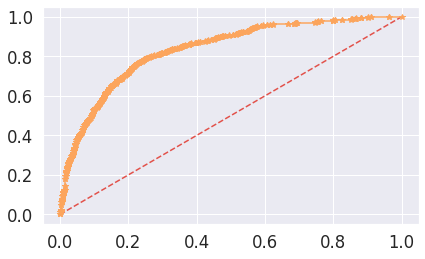

In [ ]:
# AUC-ROC curve for Training Data
probs = best.predict_proba(x_train)
probs = probs [:,1]
auc = roc_auc_score(train_labels, probs)
fpr, tpr, threshold = roc_curve(train_labels, probs)
plt.plot([0,1],[0,1], linestyle= '--')
plt.plot(fpr, tpr, marker = '*');
print('AUC:%.3f' % auc)


AUC:0.772


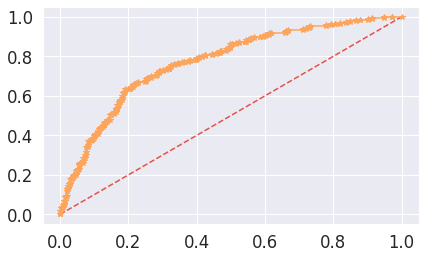

In [ ]:
# AUC-ROC curve for Testing Data
probs = best.predict_proba(x_test)
probs = probs [:,1]
auc = roc_auc_score(test_labels, probs)
fpr, tpr, threshold = roc_curve(test_labels, probs)
plt.plot([0,1],[0,1], linestyle= '--')
plt.plot(fpr, tpr, marker = '*');
print('AUC:%.3f' % auc)


In [ ]:
# Confusion matrix for Training Data
print(confusion_matrix(train_labels, ytrain_predict)) 

[[1241  133]
 [ 299  329]]


In [ ]:
# Confusion matrix for Testing Data
print(confusion_matrix(test_labels, ytest_predict)) 

[[497  75]
 [152 134]]


In [ ]:
print(classification_report(ytrain_predict, train_labels))

              precision    recall  f1-score   support

           0       0.90      0.81      0.85      1540
           1       0.52      0.71      0.60       462

    accuracy                           0.78      2002
   macro avg       0.71      0.76      0.73      2002
weighted avg       0.82      0.78      0.79      2002



In [ ]:
print(classification_report(ytest_predict, test_labels))

              precision    recall  f1-score   support

           0       0.87      0.77      0.81       649
           1       0.47      0.64      0.54       209

    accuracy                           0.74       858
   macro avg       0.67      0.70      0.68       858
weighted avg       0.77      0.74      0.75       858



Accuracy on the Training Data: 78%

Accuracy on the Test Data: 74%

AUC on the Training Data: 83%

AUC on the Test: 77%

Accuracy, AUC, Precision and Recall for test data is also slightly lower with training data.
This proves no overfitting or underfitting has happened, and overall the model is a good model for classification

# Q 2.4 Final Model: Compare all the model and write an inference which model is best/optimized.

## Model Comparision:

CART: 




Accuracy on the Training Data: 79%
Accuracy on the Test Data: 73%

AUC on the Training Data: 84%
AUC on the Test: 75%

Accuracy, AUC, Precision and Recall for test data is slightly lower 
with training data.

This proves no overfitting or underfitting has happened, and overall 
the  model is a good model for classification

Agency_code, sales and commision (in same order of preference) are 
the most important variables in determining in terms of claiming.






RANDOM FOREST:



Accuracy on the Training Data: 82%
Accuracy on the Test Data: 75%

AUC on the Training Data: 88%
AUC on the Test: 77%

Accuracy, AUC, Precision and Recall for test data is slightly in lower    
side as compare with training data.
      
This proves no overfitting or underfitting has happened, and overall 
the  model is a satisfactory model for classification

best_grid model has better improved performance over the model

The Overall model performance is moderate good to start predicting if 
Agency will go for claiming or not. 






Artificial Neural Network:



Accuracy on the Training Data: 77%
Accuracy on the Test Data: 73%

AUC on the Training Data: 85% 
AUC on the Test: 78%

Accuracy, AUC, Precision and Recall for test data is inline with 
training data. 
This proves no overfitting or underfitting has happened,   
and overall the model is a good model for classification

best_grid model has better improved performance over the model

The Overall model performance is moderate good to start predicting if 
Agency will go for claiming or not. 






Final Conclusion: 


After comparing all the three model I will go with Random Forest Model  
as the medel performace is best as compare to other models as the  
model accurract for trainig and testing data is 82% and 75% as will as 
the model has predictio for False Negative and False Posotive is 
also low as compare to other models.       


## Q 2.5 Inference: Based on the whole Analysis, what are the business insights and recommendations

### Business insights and recommendations:
 1.  Based on Random Forest model the recall for Agency who will go go for claimimg 66% is and the Agency who will not go for claimimg is 79%


 2.  The F-score which is 82% of testing data indicates a measure of a model's accuracy on a dataset. The F-score is a way of combining the precision and recall of the model, and it is defined as the harmonic mean of the model's precision and recall.
 

 3.  By Analysing the model performance It is recomended that Insurance company  should make list of such Agencies going for frequent claim and also needs to be careful will giving perticular Insurance plan to such Agencies. It is also recomded that Insurance company needs to follow propper SOP(Standard Operating Proceedure) while processing the claim.  
